Author: Pascal, pascal@bayesimpact.org

Date: 2020-10-14

# ROME update from v343 to v344

In October 2020 a new version of the ROME was released. I want to investigate what changed and whether we need to do anything about it.

You might not be able to reproduce this notebook, mostly because it requires to have the two versions of the ROME in your `data/rome/csv` folder which happens only just before we switch to v344. You will have to trust me on the results ;-)

Skip the run test because it requires older versions of the ROME.

In [1]:
import collections
import glob
import os
from os import path

import matplotlib_venn
import pandas as pd

rome_path = path.join(os.getenv('DATA_FOLDER'), 'rome/csv')

OLD_VERSION = '343'
NEW_VERSION = '344'

old_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(OLD_VERSION)))
new_version_files = frozenset(glob.glob(rome_path + '/*{}*'.format(NEW_VERSION)))

First let's check if there are new or deleted files (only matching by file names).

In [2]:
new_files = new_version_files - frozenset(f.replace(OLD_VERSION, NEW_VERSION) for f in old_version_files)
deleted_files = old_version_files - frozenset(f.replace(NEW_VERSION, OLD_VERSION) for f in new_version_files)

print('{:d} new files'.format(len(new_files)))
print('{:d} deleted files'.format(len(deleted_files)))

0 new files
0 deleted files


Cool, no new nor deleted files.

Now let's set up a dataset that, for each table, links both the old and the new file together.

In [3]:
# Load all ROME datasets for the two versions we compare.
VersionedDataset = collections.namedtuple('VersionedDataset', ['basename', 'old', 'new'])
def read_csv(filename):
    try:
        return pd.read_csv(filename)
    except pd.errors.ParserError:
        display(f'While parsing: {filename}')
        raise

rome_data = [VersionedDataset(
        basename=path.basename(f),
        old=read_csv(f.replace(NEW_VERSION, OLD_VERSION)),
        new=read_csv(f))
    for f in sorted(new_version_files)]

def find_rome_dataset_by_name(data, partial_name):
    for dataset in data:
        if 'unix_{}_v{}_utf8.csv'.format(partial_name, NEW_VERSION) == dataset.basename:
            return dataset
    raise ValueError('No dataset named {}, the list is\n{}'.format(partial_name, [d.basename for d in data]))

Let's make sure the structure hasn't changed:

In [4]:
for dataset in rome_data:
    if set(dataset.old.columns) != set(dataset.new.columns):
        print('Columns of {} have changed.'.format(dataset.basename))

OK no columns have changed.

Now let's see for each file if there are more or less rows.

In [5]:
same_row_count_files = 0
for dataset in rome_data:
    diff = len(dataset.new.index) - len(dataset.old.index)
    if diff > 0:
        print('{:d}/{:d} values added in {}'.format(
            diff, len(dataset.new.index), dataset.basename))
    elif diff < 0:
        print('{:d}/{:d} values removed in {}'.format(
            -diff, len(dataset.old.index), dataset.basename))
    else:
        same_row_count_files += 1
print('{:d}/{:d} files with the same number of rows'.format(
    same_row_count_files, len(rome_data)))

28/32273 values added in unix_coherence_item_v344_utf8.csv
15/11752 values added in unix_cr_gd_dp_appellations_v344_utf8.csv
14/13659 values added in unix_item_v344_utf8.csv
43/43901 values added in unix_liens_rome_referentiels_v344_utf8.csv
6/8983 values added in unix_referentiel_activite_riasec_v344_utf8.csv
6/8983 values added in unix_referentiel_activite_v344_utf8.csv
15/11096 values added in unix_referentiel_appellation_v344_utf8.csv
1/4930 values added in unix_referentiel_competence_v344_utf8.csv
2/5050 values added in unix_texte_v344_utf8.csv
11/20 files with the same number of rows


There are some minor changes in many files, but based on my knowledge of ROME, none from the main files.

The most interesting ones are in referentiel_appellation, item, competence, and liens_rome_referentiels, so let's see more precisely.

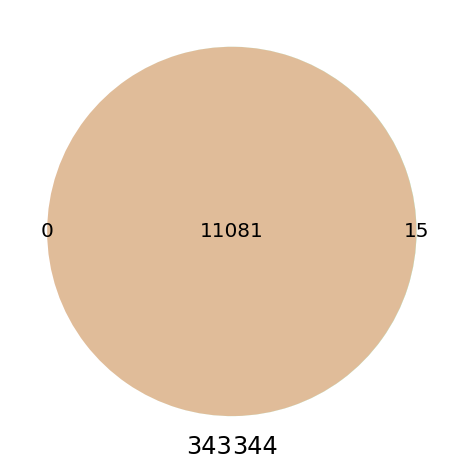

In [6]:
jobs = find_rome_dataset_by_name(rome_data, 'referentiel_appellation')

new_jobs = set(jobs.new.code_ogr) - set(jobs.old.code_ogr)
obsolete_jobs = set(jobs.old.code_ogr) - set(jobs.new.code_ogr)
stable_jobs = set(jobs.new.code_ogr) & set(jobs.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_jobs), len(new_jobs), len(stable_jobs)), (OLD_VERSION, NEW_VERSION));

Alright, so the only change seems to be 15 new jobs added. Let's take a look (only showing interesting fields):

In [7]:
pd.options.display.max_colwidth = 2000
jobs.new[jobs.new.code_ogr.isin(new_jobs)][['code_ogr', 'libelle_appellation_long', 'code_rome']]

,code_ogr,libelle_appellation_long,code_rome
11081,200100,Observateur / Observatrice des pêches,A1204
11082,200101,Murailler / Muraillère,F1703
11083,200102,Analyste vidéos de sports,G1204
11084,200103,Sushiman / Sushiwoman,G1602
11085,200104,Barista,G1801
11086,200105,Opérateur / Opératrice de production de granulés / pellets de bois,H2205
11087,200106,Agent / Agente d'entretien des piscines,I1203
11088,200107,Monteur / Monteuse sprinkler,I1304
11089,200108,Concepteur / Conceptrice pédagogique e-formation,K2111
11090,200109,Gestionnaire des aires d'accueil des gens du voyage,K2501


Those are indeed new jobs. Some are related to COVID-19 sneaking in.

OK, let's check at the changes in items:

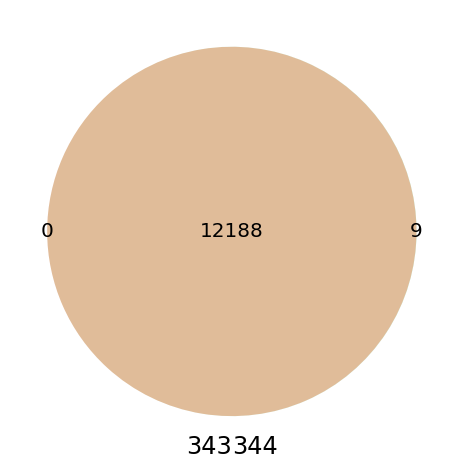

In [8]:
items = find_rome_dataset_by_name(rome_data, 'item')

new_items = set(items.new.code_ogr) - set(items.old.code_ogr)
obsolete_items = set(items.old.code_ogr) - set(items.new.code_ogr)
stable_items = set(items.new.code_ogr) & set(items.old.code_ogr)

matplotlib_venn.venn2((len(obsolete_items), len(new_items), len(stable_items)), (OLD_VERSION, NEW_VERSION));

As anticipated it is a very minor change (hard to see it visually): 9 new ones have been created. Let's have a look at them.

In [9]:
items.new[items.new.code_ogr.isin(new_items)].head()

,code_ogr,libelle,code_type_referentiel,code_ref_rubrique,code_tete_rgpmt,libelle_activite_impression,libelle_en_tete_regroupement
7978,120755,Effectuer le dérushage de séquences vidéo,2,9,NaN,NaN,NaN
8012,120819,Établir un Document Unique d'Évaluation des Risques (DUER),2,9,NaN,NaN,NaN
12889,200115,Collecter et enregistrer des données de capture de pêche,2,9,NaN,NaN,NaN
12890,200116,Analyser les vidéos de sport pour déterminer les objectifs sportifs,2,9,NaN,NaN,NaN
12891,200117,Assurer l'entretien et la maintenance de la piscine et vérifier la qualité de l'eau par des contrôles réguliers,2,9,NaN,NaN,NaN


The new ones seem legit to me and related to the new jobs.

The changes in `liens_rome_referentiels` include changes for those items, so let's only check the changes not related to those.

In [10]:
links = find_rome_dataset_by_name(rome_data, 'liens_rome_referentiels')
old_links_on_stable_items = links.old[links.old.code_ogr.isin(stable_items)]
new_links_on_stable_items = links.new[links.new.code_ogr.isin(stable_items)]

old = old_links_on_stable_items[['code_rome', 'code_ogr']]
new = new_links_on_stable_items[['code_rome', 'code_ogr']]

links_merged = old.merge(new, how='outer', indicator=True)
links_merged['_diff'] = links_merged._merge.map({'left_only': 'removed', 'right_only': 'added'})
links_merged._diff.value_counts()

added    19
Name: _diff, dtype: int64

So in addition to the added items, there are few fixes. Let's have a look at them:

In [11]:
job_group_names = find_rome_dataset_by_name(rome_data, 'referentiel_code_rome').new.set_index('code_rome').libelle_rome
item_names = items.new.set_index('code_ogr').libelle.drop_duplicates()
links_merged['job_group_name'] = links_merged.code_rome.map(job_group_names)
links_merged['item_name'] = links_merged.code_ogr.map(item_names)
display(links_merged[links_merged._diff == 'removed'].dropna().head(5))
links_merged[links_merged._diff == 'added'].dropna().head(5)

,code_rome,code_ogr,_merge,_diff,job_group_name,item_name


,code_rome,code_ogr,_merge,_diff,job_group_name,item_name
32245,A1204,100246,right_only,added,Protection du patrimoine naturel,Règles de sécurité maritime
32246,A1204,100362,right_only,added,Protection du patrimoine naturel,Procédures d'échantillonnage
32247,I1203,103106,right_only,added,Maintenance des bâtiments et des locaux,Techniques de prélèvement et d'analyses
32248,I1203,104606,right_only,added,Maintenance des bâtiments et des locaux,Utilisation de matériel de contrôle et mesure
32249,I1304,105954,right_only,added,Installation et maintenance d'équipements industriels et d'exploitation,Réaliser une opération d'assemblage / montage / ajustage


The added items are OK.

That's all the changes we wanted to check (no change in `referentiel_code_rome`).

# Conclusion

The new version of ROME, v344, introduces very minor changes which reflect quite well what they wrote in their [changelog](http://www.pole-emploi.org/files/live/sites/peorg/files/documents/Statistiques-et-analyses/Open-data/ROME/ROME_AppropriationThematique.pdf).

The transition should be transparent with a very small advantage over the old version.